In [1]:
import csv
import pandas as pd
import numpy as np
import os

## Merging dataframes

In [2]:
df_nis = pd.read_csv('data_NIS.csv')
print(df_nis.shape)
df_nis.head()

(160002, 4)


,run,timestamp,class_id,Number_in_System
0,1.0,0.000000,0.0,0.0
1,1.0,0.000000,1.0,0.0
2,1.0,1.009945,1.0,1.0
3,1.0,1.009945,0.0,0.0
4,1.0,1.263638,0.0,0.0


In [3]:
df_nis_combined = df_nis.groupby('timestamp').sum()
print(df_nis_combined.shape)
df_nis_combined.head()

(80001, 3)


,run,class_id,Number_in_System
timestamp,,,
0.000000,2.0,1.0,0.0
1.009945,2.0,1.0,1.0
1.263638,2.0,1.0,0.0
2.160614,2.0,1.0,1.0
2.608597,2.0,1.0,0.0


In [4]:
df_wiq_tis = pd.read_csv('data_WIQ_TIS.csv')
print(df_wiq_tis.shape)
df_wiq_tis = df_wiq_tis[df_wiq_tis['event_type'] == 'd']
print(df_wiq_tis.shape)
df_wiq_tis.head()

(80000, 7)
(40000, 7)


,id_run,arrival_time,timestamp,event_type,C,A,elapsed
0,0_0,1.009945,1.263638,d,1,0,0.253693
1,1_0,2.160614,2.608597,d,1,0,0.447983
2,2_0,2.653815,4.901508,d,1,0,2.247693
3,3_0,3.522926,5.556008,d,1,0,2.033082
4,4_0,4.546470,6.800055,d,0,0,2.253586


In [5]:
new_df = pd.merge(df_nis_combined, df_wiq_tis,  how='inner', left_on=['timestamp'], right_on = ['arrival_time'])
print(new_df.shape)
new_df.head()

(40000, 10)


,run,class_id,Number_in_System,id_run,arrival_time,timestamp,event_type,C,A,elapsed
0,2.0,1.0,1.0,0_0,1.009945,1.263638,d,1,0,0.253693
1,2.0,1.0,1.0,1_0,2.160614,2.608597,d,1,0,0.447983
2,2.0,1.0,1.0,2_0,2.653815,4.901508,d,1,0,2.247693
3,2.0,1.0,2.0,3_0,3.522926,5.556008,d,1,0,2.033082
4,2.0,1.0,3.0,4_0,4.546470,6.800055,d,0,0,2.253586


In [6]:
new_df = new_df[['arrival_time', 'C', 'Number_in_System', 'elapsed']]
new_df.columns = ['arrival_time', 'Type_No_Consult','NIS','LOS']
new_df

,arrival_time,Type_No_Consult,NIS,LOS
0,1.009945,1,1.0,0.253693
1,2.160614,1,1.0,0.447983
2,2.653815,1,1.0,2.247693
3,3.522926,1,2.0,2.033082
4,4.546470,0,3.0,2.253586
...,...,...,...,...
39995,44498.968327,1,5.0,6.855732
39996,44499.227551,1,6.0,10.480218
39997,44499.550381,1,7.0,10.846060
39998,44500.187678,1,7.0,10.893223


In [7]:
df_test = new_df[75:]
df_test.head()

,arrival_time,Type_No_Consult,NIS,LOS
75,84.233729,1,2.0,4.208967
76,84.497065,1,3.0,4.119121
77,87.490464,1,3.0,2.089174
78,87.558266,1,4.0,2.219138
79,88.914941,1,3.0,0.954941


In [8]:
x_test = df_test[['Type_No_Consult', 'NIS']]
y_test = df_test[['LOS']]

In [9]:
x_test.head()

,Type_No_Consult,NIS
75,1,2.0
76,1,3.0
77,1,3.0
78,1,4.0
79,1,3.0


In [10]:
y_test.head()

,LOS
75,4.208967
76,4.119121
77,2.089174
78,2.219138
79,0.954941


In [11]:
new_df.to_csv('MM1_baseline.csv', index=False)

In [12]:
np.mean(new_df['LOS'])

20.091031206481784

## Naive calculation

In [13]:
def naive_calculations(df, cutdown):
    los_list = []
    for j in range(len(df)):
        if df['Type_No_Consult'][j] == 0:  # consult patient
            los_list.append(df['LOS'][j] * cutdown)
        else:
            los_list.append(df['LOS'][j])

    mean = round(np.mean(los_list), 2)
    median = round(np.median(los_list), 2)
    stdev = round(np.std(los_list), 2)
    P90 = round(np.percentile(los_list, q=90), 2)

    return mean, median, stdev, P90

In [14]:
new_df

,arrival_time,Type_No_Consult,NIS,LOS
0,1.009945,1,1.0,0.253693
1,2.160614,1,1.0,0.447983
2,2.653815,1,1.0,2.247693
3,3.522926,1,2.0,2.033082
4,4.546470,0,3.0,2.253586
...,...,...,...,...
39995,44498.968327,1,5.0,6.855732
39996,44499.227551,1,6.0,10.480218
39997,44499.550381,1,7.0,10.846060
39998,44500.187678,1,7.0,10.893223


In [15]:
# Training data
df_train = new_df[20000:30000].reset_index(drop=True)
# df_test = new_df[30000:].reset_index(drop=True)

df = df_train.copy()
# df = df_test.copy()

nPatients = len(df)
nConsultPatients = len(df[df['Type_No_Consult'] == 0])
percentConsult = round(nConsultPatients / nPatients * 100, 1)

df_results = pd.DataFrame(
    columns=['nPatients', 'nConsultPatients', 'percentConsult', 'Cut Down by (%)', 'Mean', 'Median',
             'Stdev', '90th Percentile'])

# cutdown_percentage = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cutdown_percentage = [0.5, 1.0]
for i, cutdown in enumerate(cutdown_percentage):
    print("Consult Patients shorten by {} Percent".format((1-cutdown)*100))
    mean, median, stdev, P90 = naive_calculations(df, cutdown)
    df_results.loc[i] = nPatients, nConsultPatients, percentConsult, (
                1 - cutdown) * 100, mean, median, stdev, P90

print(df_results)

save_path_results = os.path.join(os.getcwd(), "Consult_Reduction_Results_Naive_MM1_train.csv")
df_results.to_csv(save_path_results, index=False, header=True)

Consult Patients shorten by 50.0 Percent
Consult Patients shorten by 0.0 Percent
   nPatients  nConsultPatients  percentConsult  Cut Down by (%)   Mean  \
0    10000.0             961.0             9.6             50.0  15.76   
1    10000.0             961.0             9.6              0.0  16.57   

   Median  Stdev  90th Percentile  
0   11.71  13.40             35.4  
1   12.71  13.68             36.8  


# M/M/1 (40000 samples generated from M/M/1 simulator) - 1 general nis

In [16]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np

In [17]:
def open_list_of_csv(csv_list):
    los_list = [[],[],[],[],[]]
    for i, filename in enumerate(csv_list):
        print(filename)
        with open(filename, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                los_list[i].append(float(row[0]))
    return los_list

In [18]:
def plot_los_distributions(los_list, title, x_lim):
    figure(figsize=(8, 6), dpi=80)
    sns.set_color_codes("colorblind")
    sns.histplot(los_list[0], bins='auto', element="step", label='Actual LOS', color='b', alpha=0.2)
    sns.histplot(los_list[1], bins='auto', element="step", label='Simulated LOS', color='g', alpha=0.2)

    plt.legend()
    plt.title('Actual vs. Simulated LOS Distribution ({})'.format(title))
    plt.ylabel('Frequency')
    plt.xlim(0, x_lim)
    plt.show

In [19]:
# plt.hist(los_list[0], bins = 50)

# Out of Sample Test: Train on samples 10k-30k, Test on samples 30k-40k

In [20]:
ofs_csv_list = ['outofsample_LOS_Dist_Actual_MM1 - train10-30k test30-40k.csv', 'outofsample_LOS_Dist_Simulated_MM1 - train10-30k test30-40k (1run).csv']

In [21]:
ofs_los_list = open_list_of_csv(ofs_csv_list)

outofsample_LOS_Dist_Actual_MM1 - train10-30k test30-40k.csv
outofsample_LOS_Dist_Simulated_MM1 - train10-30k test30-40k (1run).csv


In [22]:
len(ofs_los_list[0]), len(ofs_los_list[1])

(10000, 10000)

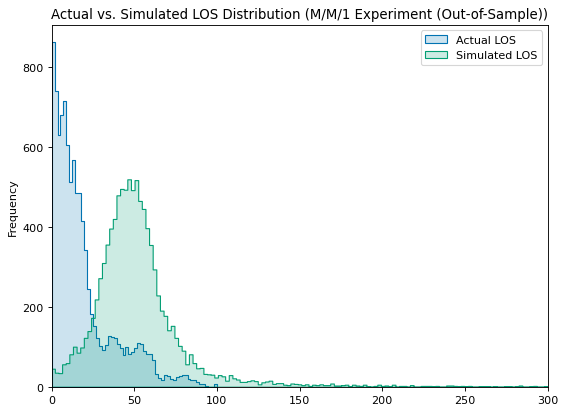

In [23]:
plot_los_distributions(ofs_los_list, 'M/M/1 Experiment (Out-of-Sample)', 300)

In [24]:
print('actual mean los (1 run)', np.mean(ofs_los_list[0])) 
print('simulated mean los (1 run)', np.mean(ofs_los_list[1]))

actual mean los (1 run) 19.547403590587972
simulated mean los (1 run) 52.58259143393291


# In Sample Test: Train on samples 10k-30k, Test on samples 20k-30k

In [25]:
is_csv_list = ['insample_LOS_Dist_Actual_MM1 - train10k-30k test20k-30k.csv', 'insample_LOS_Dist_Simulated_MM1 - train10k-30k test20k-30k (1run).csv']

In [26]:
is_los_list = open_list_of_csv(is_csv_list)

insample_LOS_Dist_Actual_MM1 - train10k-30k test20k-30k.csv
insample_LOS_Dist_Simulated_MM1 - train10k-30k test20k-30k (1run).csv


In [27]:
len(is_los_list[0]), len(is_los_list[1])

(10000, 10000)

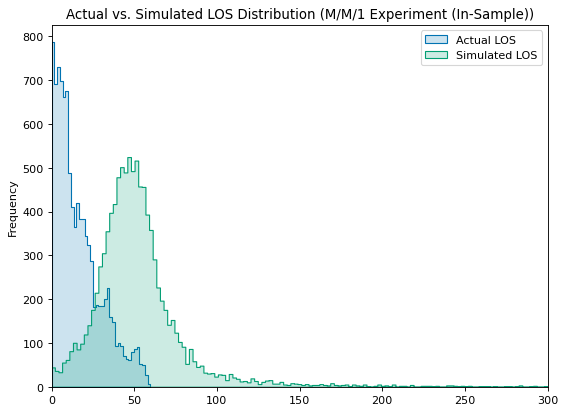

In [28]:
plot_los_distributions(is_los_list, 'M/M/1 Experiment (In-Sample)', 300)

In [29]:
print('actual mean los (1 run)', np.mean(is_los_list[0])) 
print('simulated mean los (1 run)', np.mean(is_los_list[1]))

actual mean los (1 run) 16.57360031083062
simulated mean los (1 run) 52.60250720965008
